In [13]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from utils import *
from train import fit, evaluate
import CNN, DNN, MLP
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import seaborn as sns

## We work on the 2D dataset with size 28x28

In [14]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [15]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)

write_log('train_dataset_log.txt', str(train_dataset))
write_log('test_dataset_log.txt', str(test_dataset))
write_log('validation_dataset_log.txt', str(validation_dataset))

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Train: torch.Size([11959, 2352]), Test: torch.Size([3421, 2352])
Epoch [1/1], Loss: 1.4299
Training Accuracy: 46.72%
Epoch [1/15] - Test Loss: 1.0338, Test Acc: 63.84%, F1: 0.6092
Epoch [1/1], Loss: 1.4299
Training Accuracy: 46.72%
Epoch [1/15] - Test Loss: 1.0338, Test Acc: 63.84%, F1: 0.6092
Epoch [1/1], Loss: 0.9781
Training Accuracy: 64.67%
Epoch [2/15] - Test Loss: 0.9113, Test Acc: 67.14%, F1: 0.6708
Epoch [1/1], Loss: 0.9781
Training Accuracy: 64.67%
Epoch [2/15] - Test Loss: 0.9113, Test Acc: 67.14%, F1: 0.6708
Epoch [1/1], Loss: 0.8806
Training Accuracy: 68.57%
Epoch [3/15] - Test Loss: 0.9288, Test Acc: 68.72%, F1: 0.6998
Epoch [1/1], Loss: 0.8806
Training Accuracy: 68.57%
Epoch [3/15] - Test Loss: 0.9288, Test Acc: 68.72%, F1: 0.6998
Epoch [1/1], Loss: 0.8350
Training Accuracy: 69.90%
Epoch [4/15] - Test Loss: 0.8423, Test Acc: 71.59%, F1: 0.7235
Epoch [1/1], Loss: 0.8350
Training Accuracy: 69.90%
Epoch [4/15] - Test Loss: 0.8423, Test Acc: 71.59%, F1: 0.7235
Epoch [1/1], Lo

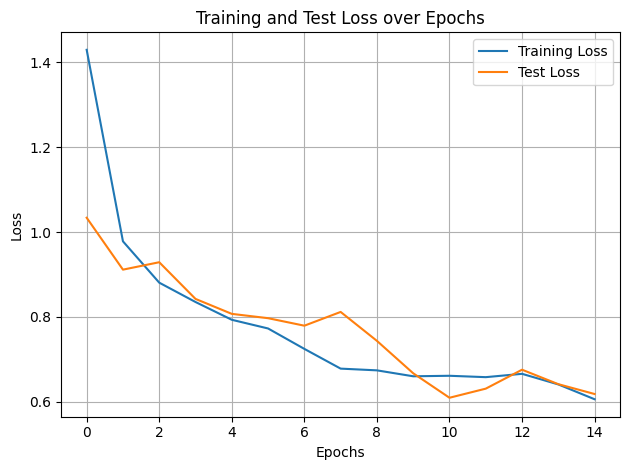

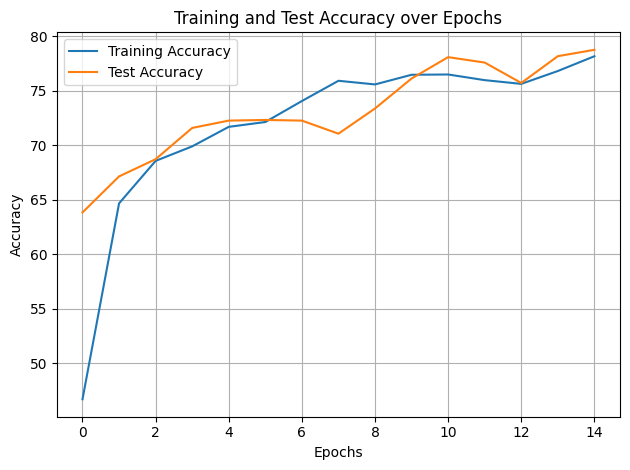

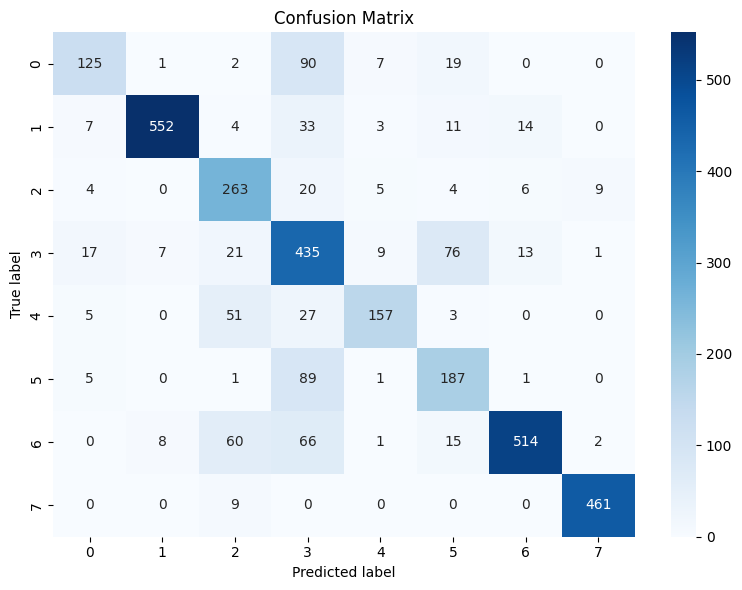

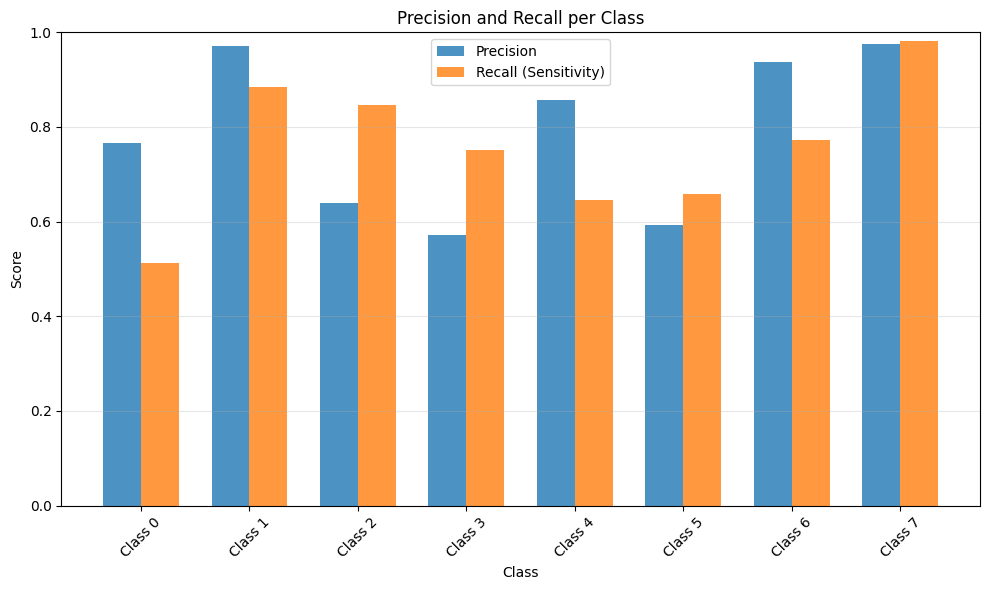

In [ ]:
# variables declaration
model_type = 'MLNN'
n_epochs = 15
n_layers = 1
n_inputs = n_channels * 28 * 28
size_hidden_layer = (n_inputs + n_classes) // 2 # n_classes = n_outputs
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001


device = get_device()

assert device is not None

write_log('main_log.txt', f'Using device: {device}\n')

assert model_type is not None

if model_type == 'CNN':
    model = CNN.CNN(n_channels, n_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train, y_train = process_data(train_loader, flag=False)
    X_test, y_test = process_data(test_loader, flag=False)

    # Train and evaluate per epoch
    training_losses = []
    training_accs = []
    test_losses = []
    test_accs = []
    test_f1s = []
    
    for epoch in range(n_epochs):
        # Train one epoch
        epoch_losses, epoch_accs, model = fit(
            device, X_train, y_train, model, loss_function, optimizer, 
            n_epochs=1, batch_size=BATCH_SIZE
        )
        training_losses.extend(epoch_losses)
        training_accs.extend(epoch_accs)
        
        # Evaluate on test set
        CM_test, f1_test, loss_test, acc_test = evaluate(
            device, X_test, y_test, model, loss_function
        )
        test_losses.append(loss_test)
        test_accs.append(acc_test)
        test_f1s.append(f1_test)
        
        print(f"Epoch [{epoch+1}/{n_epochs}] - Test Loss: {loss_test:.4f}, Test Acc: {acc_test:.2f}%, F1: {f1_test:.4f}")
    
    trained_model = model
    
    # Final confusion matrix and metrics
    CM, f1, final_test_loss, final_test_acc = evaluate(
        device, X_test, y_test, trained_model, loss_function
    )
    
    precision, sensitivity, specificity = get_metrics(CM)
    complexity = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)
    
    # Calculate macro averages
    macro_precision = np.mean(precision)
    macro_sensitivity = np.mean(sensitivity)
    macro_specificity = np.mean(specificity)
    
    # Save results
    write_log('training_history.txt',
              f'Training Losses: {training_losses}\n'
              f'Training Accuracies: {training_accs}\n'
              f'Test Losses: {test_losses}\n'
              f'Test Accuracies: {test_accs}\n'
              f'Test F1 Scores: {test_f1s}\n')
    
    write_log('final_results.txt',
              f'Final Confusion Matrix:\n{CM}\n'
              f'F1 Score: {f1:.4f}\n'
              f'Test Loss: {final_test_loss:.4f}\n'
              f'Test Accuracy: {final_test_acc:.2f}%\n'
              f'Complexity: {complexity:,} parameters\n'
              f'Macro Precision: {macro_precision:.4f}\n'
              f'Macro Sensitivity: {macro_sensitivity:.4f}\n'
              f'Macro Specificity: {macro_specificity:.4f}\n')
    
    # Plot comparisons
    plot_loss(training_losses, test_losses)
    plot_acc(training_accs, test_accs)
    plot_confusion_matrix(CM, n_classes)
    plot_precision_recall(precision, sensitivity, n_classes)
    
    print(f"\nFinal Results:")
    print(f"Test Loss: {final_test_loss:.4f}, Test Acc: {final_test_acc:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Complexity: {complexity:,} parameters")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Sensitivity: {macro_sensitivity:.4f}")
    print(f"Macro Specificity: {macro_specificity:.4f}")
    


elif model_type == 'MLNN':
    model = MLP.MLP(n_inputs, [size_hidden_layer] * n_layers, n_classes, 0.2)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum0.9)    


    # Process data
    X_train, y_train = process_data(train_loader)
    X_test, y_test = process_data(test_loader)
    
    print(f"Train: {X_train.shape}, Test: {X_test.shape}") 
    write_log("main_log.txt", f"Processed data shapes: Train: {X_train.shape}, Test: {X_test.shape}\n")
    
    # Train and evaluate per epoch
    training_losses = []
    training_accs = []
    test_losses = []
    test_accs = []
    test_f1s = []
    
    for epoch in range(n_epochs):
        # Train one epoch
        epoch_losses, epoch_accs, model = fit(
            device, X_train, y_train, model, loss_function, optimizer, 
            n_epochs=1, batch_size=BATCH_SIZE
        )
        training_losses.extend(epoch_losses)
        training_accs.extend(epoch_accs)
        
        # Evaluate on test set
        CM_test, f1_test, loss_test, acc_test = evaluate(
            device, X_test, y_test, model, loss_function
        )
        test_losses.append(loss_test)
        test_accs.append(acc_test)
        test_f1s.append(f1_test)
        
        print(f"Epoch [{epoch+1}/{n_epochs}] - Test Loss: {loss_test:.4f}, Test Acc: {acc_test:.2f}%, F1: {f1_test:.4f}")
    
    trained_model = model
    
    # Final confusion matrix and metrics
    CM, f1, final_test_loss, final_test_acc = evaluate(
        device, X_test, y_test, trained_model, loss_function
    )
    
    precision, sensitivity, specificity = get_metrics(CM)
    complexity = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)
    
    # Calculate macro averages
    macro_precision = np.mean(precision)
    macro_sensitivity = np.mean(sensitivity)
    macro_specificity = np.mean(specificity)
    
    # Save results
    write_log('training_history.txt',
              f'Training Losses: {training_losses}\n'
              f'Training Accuracies: {training_accs}\n'
              f'Test Losses: {test_losses}\n'
              f'Test Accuracies: {test_accs}\n'
              f'Test F1 Scores: {test_f1s}\n')
    
    write_log('final_results.txt',
              f'Final Confusion Matrix:\n{CM}\n'
              f'F1 Score: {f1:.4f}\n'
              f'Test Loss: {final_test_loss:.4f}\n'
              f'Test Accuracy: {final_test_acc:.2f}%\n'
              f'Complexity: {complexity:,} parameters\n'
              f'Macro Precision: {macro_precision:.4f}\n'
              f'Macro Sensitivity: {macro_sensitivity:.4f}\n'
              f'Macro Specificity: {macro_specificity:.4f}\n')
    
    # Plot comparisons
    plot_loss(training_losses, test_losses)
    plot_acc(training_accs, test_accs)
    plot_confusion_matrix(CM, n_classes)
    plot_precision_recall(precision, sensitivity, n_classes)
    
    print(f"\nFinal Results:")
    print(f"Test Loss: {final_test_loss:.4f}, Test Acc: {final_test_acc:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Complexity: {complexity:,} parameters")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Sensitivity: {macro_sensitivity:.4f}")
    print(f"Macro Specificity: {macro_specificity:.4f}")
    
else:
    # model = MLP.MLP()
    pass



